# Fiting a SED

In [1]:
import matplotlib.pyplot as plt
import torch
import sedpy
import starduster
from scipy.optimize import minimize

torch.set_num_threads(1)
torch.manual_seed(999);

This tutorial demonstrates how to fit a SED. We start by building the SED model.

In [2]:
sed_model = starduster.MultiwavelengthSED.from_builtin()
sed_model.configure(
    pset_gp=starduster.GalaxyParameter(),
    pset_sfh_disk=starduster.InterpolatedSFH(),
    pset_sfh_bulge=starduster.InterpolatedSFH(),
    flat_input=True,
)

We then create some mock photometric data. The easiest way to ouput filter fluxes is to use the transmission curves given by ``sedpy``.

In [3]:
band_names = [
    'galex_FUV', 'galex_NUV',
    'sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0',
    'twomass_J', 'twomass_H', 'twomass_Ks',
    'wise_w1', 'wise_w2', 'wise_w3', 'wise_w4',
    'herschel_pacs_100', 'herschel_pacs_160',
    'herschel_spire_250', 'herschel_spire_350', 'herschel_spire_500'
]
filters = sedpy.observate.load_filters(band_names)
redshift = 0.01
distmod= 0.
sed_model.configure(filters=filters, redshift=redshift, distmod=distmod, ab_mag=True)
# Generate a random SED
params_true = starduster.sample_effective_region(sed_model)
with torch.no_grad():
    mags = sed_model(params_true, return_ph=True)
# We assume 0.1 mag error for every band
mags_err = torch.full_like(mags, 0.1)

The figure below shows the mock SED.

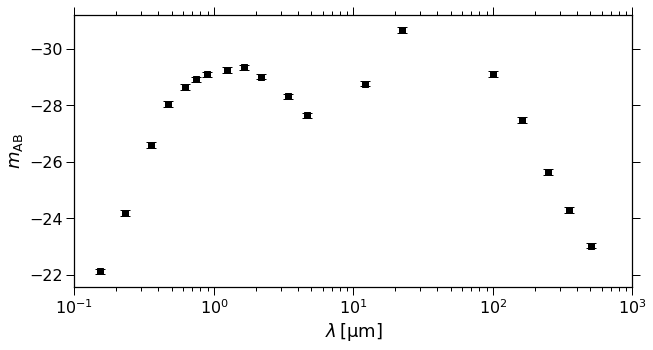

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))

lam_pivot = sed_model.lam_pivot.numpy()
plt.errorbar(lam_pivot, mags.numpy(), mags_err.numpy(), fmt='ks')

ax.set_xscale('log')
ax.set_xlabel(r'$\lambda \, [\rm \mu m]$')
ax.set_ylabel(r'$m_{\rm AB}$')
ax.set_xlim(.1, 1e3)
ax.invert_yaxis()

This next step is to build the posterior distribution. ``Posterior`` is callable, which provides a good interface for various optimisers and sampling tools.

In [5]:
error_func = starduster.Gaussian(mags, mags_err, norm=False)
posterior = starduster.Posterior(sed_model, error_func)
# Create the initial value for the optimiser
eps = 0.1
sampler = lambda n_samp: params_true + eps*(2*torch.rand(n_samp, len(params_true)) - 1)
params_0 = starduster.sample_effective_region(sed_model, sampler=sampler)

The following code uses the Adam optimiser given by PyTorch to fit the SED. This optimiser requires the first-order gradient.

In [6]:
posterior.configure_output_mode(output_mode='torch', negative=True, log_out=0.)
params_pred = starduster.optimize(
    posterior, torch.optim.Adam, params_0, n_step=300, lr=1e-2
)

loss: 4.669e-03: 100%|██████████| 300/300 [00:06<00:00, 46.55it/s]


We may also use the Scipy LBFGS optimiser. We can pass the first-order gradient by setting ``jac=True``.

In [7]:
posterior.configure_output_mode(output_mode='numpy_grad', negative=True, log_out=0.)
res_bfgs = minimize(
    posterior, params_0.numpy(), bounds=posterior.bounds, method='L-BFGS-B', jac=True
)
params_bfgs = res_bfgs.x

Additonaly, we can also employ a optimiser that does not require the gradient. The following output mode can also be applied to a MCMC sampler.

In [8]:
posterior.configure_output_mode(output_mode='numpy', negative=True)
res_powell = minimize(
    posterior, params_0.numpy(), bounds=posterior.bounds, method='Powell'
)
params_powell = res_powell.x

We compare the results obtained by different optimisers as follows. The results are consistent.

In [9]:
print("\tTrue\tAdam\tLBFGS\tPowell")
for params in zip(params_true, params_pred, params_bfgs, params_powell):
    print("\t%.2f\t%.2f\t%.2f\t%.2f"%params)

	True	Adam	LBFGS	Powell
	0.60	0.71	0.73	0.88
	0.27	0.31	0.28	0.31
	-0.16	-0.24	-0.19	-0.24
	-0.14	-0.14	-0.14	-0.14
	-0.39	-0.43	-0.42	-0.43
	0.86	0.86	0.86	0.86
	-0.93	-0.91	-0.92	-0.91
	-0.96	-0.95	-0.94	-0.93
	9.70	9.70	9.69	9.70
	-1.19	-1.19	-1.18	-1.12
	9.65	9.73	9.72	9.61


The fitting result can be seen in the figure below.

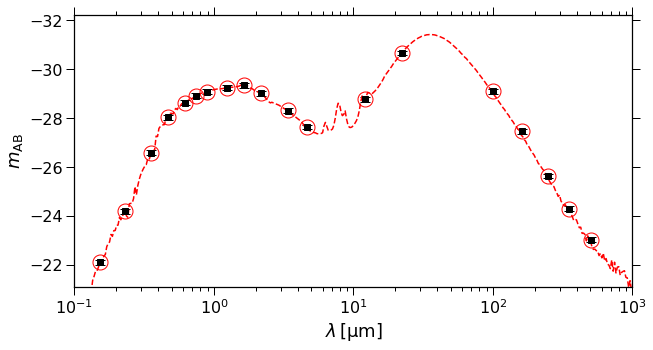

In [10]:
# Compute the fitting result
with torch.no_grad():
    f_nu = sed_model(params_pred)
    f_ab = -2.5*torch.log10(f_nu) + 8.9
    mags_pred = sed_model(params_pred, return_ph=True)

# Plot the result
fig, ax = plt.subplots(figsize=(10, 5))

plt.errorbar(lam_pivot, mags, mags_err.numpy(), fmt='ks')
plt.plot(lam_pivot, mags_pred, 'ro', markersize=15, markerfacecolor='none')
plt.plot(sed_model.lam, f_ab, 'r--')

ax.set_xscale('log')
ax.set_xlabel(r'$\lambda \, [\rm \mu m]$')
ax.set_ylabel(r'$m_{\rm AB}$')
ax.set_xlim(.1, 1e3)
ax.set_ylim(top=mags.numpy().max() + 1)
ax.invert_yaxis()